In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
df = pd.read_csv('Spotify_Combined.csv')
df.drop(['index','id','uri','artist','name'], axis=1, inplace=True)

### Fixing multi-class labels using clustering to assign to the closest single-class group. Using 13 neighbors based on the best result from prior analysis in HW1

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.model_selection import StratifiedKFold

In [4]:
def perfReport(ytest, ypredict, output='metrics'): 
    cm = pd.DataFrame(data=confusion_matrix(ytest, ypredict, 
                      labels=['dinner', 'sleep', 'workout', 'party']),
                      columns=['dinner_pred', 'sleep_pred', 
                               'workout_pred', 'party_pred'],
                      index=['dinner_true', 'sleep_true', 
                             'workout_true', 'party_true'])
    
    cols = ['Sensitivity', 'Specificity', 'F1', 'Accuracy']
    dfperf = pd.DataFrame(index=['dinner', 'sleep', 'workout', 
                                 'party'], 
                          columns=cols)
    
    diagsum = 0
    for i in range(0,len(cm)):
        diagsum += cm.iloc[i,i]
    
    for j in range(0, len(cm)):
        tp = cm.iloc[j,j]
        fn = int(cm.iloc[:,j].sum())-tp
        fp = int(cm.iloc[j,:].sum())-tp
        tn = diagsum - tp

        sens = float(tp) / (tp+fn)
        spec = float(tn) / (tn+fp)
        f1 = (2*float(tp)) / (2*tp+fp+fn)
        acc = float(tp+tn) / (tp+tn+fp+fn)

        dfperf.iloc[j,0] = sens
        dfperf.iloc[j,1] = spec
        dfperf.iloc[j,2] = f1
        dfperf.iloc[j,3] = acc
            
    if output == 'metrics':
        return dfperf
    elif output == 'cm':
        return cm

In [5]:
def KNNpipe(xtrn, xtst, ytrn, ytst, nneigh=3, scaled=1, output='stats'):
    if scaled == 1:
        mypipeline = Pipeline([
            ('myscaler', StandardScaler()),
            ('masterAlg', KNeighborsClassifier(n_neighbors=nneigh))
        ])
    else:
        mypipeline = Pipeline([
            ('masterAlg', KNeighborsClassifier(n_neighbors=nneigh))
        ])
    
    mypipeline.fit(xtrn, ytrn)
    yprd = mypipeline.predict(xtst)
    yprd_prob = mypipeline.predict_proba(xtst)
    
    if output == 'stats':
        return perfReport(ytst, yprd)
    elif output == 'raw':
        return yprd
    elif output == 'cm':
        return perfReport(ytst, yprd, output='cm')

In [6]:
#making a list of the combination values to exclude, and a copy of the dataframe without them
exclude_vals = ['party, workout', 'dinner, party', 'dinner, workout']

df_multi = df.loc[df['mood(s)'].isin(exclude_vals)]
df_f = df.loc[~df['mood(s)'].isin(exclude_vals) ]

In [15]:
#setting up attributes and targets, and splitting into stratified training, testing, and validation...
#... with the multi-label classes excluded at the moment
# 66/33 training and testing in the first split of df_f
# 80/20 of the training from the previous split for training and testing in fixing multi-labels
# => 53% training and 13% testing as a subset of the full 66% training (fixing multi-labels)
# Training and testing will be used for learning best labels to put on mulit-label mood instances...
#... and then the multi-labels will be added to testing and the full 66% used for training with the...
#...33% testing to determine the best model

seed = 3
X, y = df_f.iloc[:, 0:len(df_f.columns)-1], df_f['mood(s)']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.33, 
                                                    random_state=seed)

X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train, y_train,
                                                               stratify=y_train,
                                                               test_size=0.20,
                                                               random_state=seed)

# setting the multi-labels as validation sets for the subtraining to fix labels
X_subval, y_subval = df_multi.iloc[:, 0:len(df_multi.columns)-1], df_multi['mood(s)']

In [16]:
y_subvalpred = KNNpipe(X_subtrain, X_subval, y_subtrain, y_subval,
                    nneigh=13, scaled=1, output='raw')

In [17]:
# removing old combination label and using the model to attribute new labels
df_multi.drop('mood(s)', axis=1, inplace=True) 
df_multi = pd.concat([df_multi, 
                      pd.DataFrame(data=y_subvalpred, index=df_multi.index, columns=['mood(s)'])],
                     axis=1, ignore_index=False)

In [18]:
# combining the edited multi-class dataset with the full training set
X_train = pd.concat([df_multi.iloc[:,0:len(df_multi.columns)-1], X_train.copy()])
y_train = pd.concat([df_multi.iloc[:,len(df_multi.columns)-1], y_train.copy()])

In [19]:
#making a copy of the full dataframe with fixed multi-class labels
X_temp = pd.concat([X_train, X_test])
y_temp = pd.concat([y_train, y_test])
df2 = pd.concat([X_temp, y_temp], axis=1)  
### df2 is now the full data set with fixed labels for the multi-class instances

Text(0.5,1,u"Class 'Mood' Distribution")

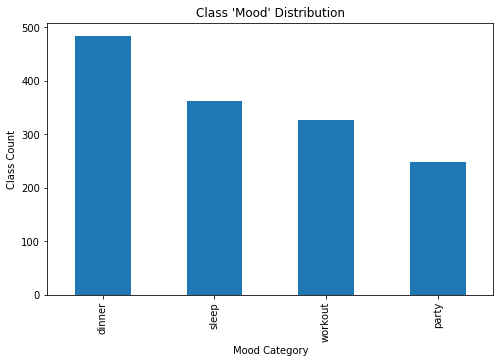

In [20]:
#plotting the distribution. 
#more balance with the fixed labels, but still some class imbalance
figure(figsize=(8,5))
df2['mood(s)'].value_counts().plot(kind='bar')
plt.xlabel("Mood Category")
plt.ylabel("Class Count")
plt.title("Class 'Mood' Distribution")

#### Repeating the DT and NB models 30 times and reporting the means, variances, and confidence intervals for the accuracy results on both the training and testing sets. 

###### Decision tree analysis x30. Using optimal parameters chosen from previous analysis based on the balance of good classfication ability and favoring a simpler model. Using entropy as splitting cirterion, balanced class wights, min number of samples for a parent node equal to 20, min number of samples for a leaf node equal to 15

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import random
import math
from scipy import stats

In [23]:
def classificationReport(arr, CI = 0.95, nsamp=100):  
    def resample(S, size=None):
        return [random.choice(S) for i in xrange(size or len(S))]
   
    def bootstrap(x, confidence=CI, nsamples=nsamp):
        def mean(S):
            return float(sum(x for x in S))/len(S)
        means = [mean(resample(x)) for k in xrange(nsamples)]
        means.sort()
        left_tail = int(((1.0-confidence)/2)*nsamples)
        right_tail = nsamples-1-left_tail
        return means[left_tail], mean(x), means[right_tail]
    
    arr = map(float, arr)
    mean = sum(arr) / len(arr)
    var = sum([(i-mean)**2 for i in arr]) / len(arr)
    ci_analytic = stats.norm.interval(CI, loc=mean, scale=np.sqrt(var))
    ci_boot = bootstrap(arr, confidence=CI, nsamples=nsamp)
    
    return (mean, var, ci_analytic, ci_boot)

In [24]:
def manyRuns(df, test="generalization", niters=30, test_size=0.33, output='acc'):
    tree_table = pd.DataFrame(columns=['Accuracy'])
    nb_table = pd.DataFrame(columns=['Accuracy'])
    
    res_table = pd.DataFrame(columns=['DT Accuracy', 'NB Accuracy'])
   
    for i in range(0, niters):
        df = df.sample(frac=1)
        tmp_X, tmp_y = df.iloc[:, 0:len(df.columns)-1], df['mood(s)']
        tmp_Xtrain, tmp_Xtest, tmp_ytrain, tmp_ytest = train_test_split(tmp_X, tmp_y,
                                                                        stratify=tmp_y,
                                                                        test_size=test_size,
                                                                        )
        tree_pipe = Pipeline([
            ('myscaler', StandardScaler()),
            ('masteralg', DecisionTreeClassifier(random_state=0,
                                     criterion='entropy',
                                     class_weight='balanced',
                                     min_samples_split=20,
                                     min_samples_leaf=15))
        ])
        tree_pipe.fit(tmp_Xtrain, tmp_ytrain)
        
        nb_pipe = Pipeline([
            ('myscaler', StandardScaler()),
            ('masteralg', GaussianNB())
        ])
        nb_pipe.fit(tmp_Xtrain, tmp_ytrain)

        if test == "generalization":
            tree_ypred = tree_pipe.predict(tmp_Xtest)
            tree_acc = accuracy_score(tmp_ytest, tree_ypred)

            nb_ypred = nb_pipe.predict(tmp_Xtest)
            nb_acc = accuracy_score(tmp_ytest, nb_ypred)

        elif test == "resubstitution":
            tree_ypred = tree_pipe.predict(tmp_Xtrain)
            tree_acc = accuracy_score(tmp_ytrain, tree_ypred)

            nb_ypred = nb_pipe.predict(tmp_Xtrain)
            nb_acc = accuracy_score(tmp_ytrain, nb_ypred)

        res_table = res_table.append(pd.DataFrame(data=np.array([[tree_acc,
                                                                  nb_acc]]),
                                                  columns=['DT Accuracy',
                                                           'NB Accuracy']),
                                     ignore_index=True)

        
    return res_table

In [25]:
def plotAcc(dist, finish_title):
    figure(figsize=(8,5))
    plt.hist(dist, bins=len(dist))
    plt.ylabel('Count')
    plt.xlabel('Accuracy')
    plt.title('Distribution of Accuracy Scores for '+finish_title)    

In [26]:
#two results tables, one for resubtitution, one for generalization

res_gen = manyRuns(df2, test='generalization', niters=30)
res_resub = manyRuns(df2, test='resubstitution', niters=30)

Evaluating average resubtitution performance on 30 trees

In [27]:
tree_acc = res_resub['DT Accuracy'].as_matrix()
tree_scores = classificationReport(tree_acc, CI=0.95, nsamp=100000)

print "Mean accuracy of 30 trees on shuffled training/testing data = {0:.2f}%" \
                                                    .format(tree_scores[0]*100)
print "Variance of accuracy from 30 trees on shuffled training/testing data = {0:.3f}%"\
                                                    .format(tree_scores[1]*100)
print "Analytic confidence interval of 95% for accuracy has range {0:.2f}% to {1:.2f}%"\
                            .format(tree_scores[2][0]*100,tree_scores[2][1]*100)
print "Bootstrap confidence interval of 95% for accuracy has range {0:.2f}% to {1:.2f}%"\
                            .format(tree_scores[3][0]*100,tree_scores[3][2]*100)

Mean accuracy of 30 trees on shuffled training/testing data = 81.84%
Variance of accuracy from 30 trees on shuffled training/testing data = 0.012%
Analytic confidence interval of 95% for accuracy has range 79.70% to 83.97%
Bootstrap confidence interval of 95% for accuracy has range 81.45% to 82.23%


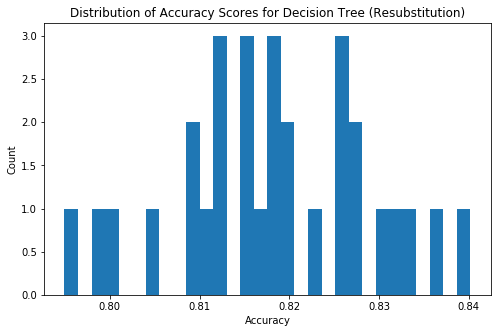

In [28]:
plotAcc(res_resub['DT Accuracy'], "Decision Tree (Resubstitution)")

Evaluating average generalization performance on 30 trees

In [29]:
tree_acc = res_gen['DT Accuracy'].as_matrix()
tree_scores = classificationReport(tree_acc, CI=0.95, nsamp=100000)

print "Mean accuracy of 30 trees on shuffled training/testing data = {0:.2f}%" \
                                                    .format(tree_scores[0]*100)
print "Variance of accuracy from 30 trees on shuffled training/testing data = {0:.3f}%"\
                                                    .format(tree_scores[1]*100)
print "Analytic confidence interval of 95% for accuracy has range {0:.2f}% to {1:.2f}%"\
                            .format(tree_scores[2][0]*100,tree_scores[2][1]*100)
print "Bootstrap confidence interval of 95% for accuracy has range {0:.2f}% to {1:.2f}%"\
                            .format(tree_scores[3][0]*100,tree_scores[3][2]*100)

Mean accuracy of 30 trees on shuffled training/testing data = 74.48%
Variance of accuracy from 30 trees on shuffled training/testing data = 0.046%
Analytic confidence interval of 95% for accuracy has range 70.29% to 78.68%
Bootstrap confidence interval of 95% for accuracy has range 73.71% to 75.25%


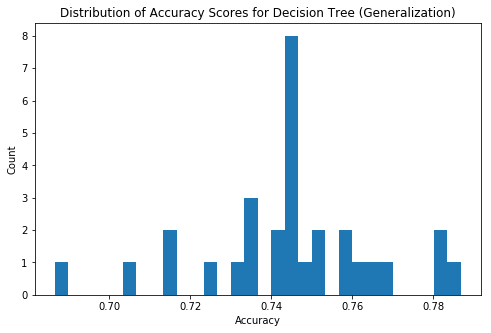

In [30]:
plotAcc(res_gen['DT Accuracy'], "Decision Tree (Generalization)")

#### Naive bayes analysis x30

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Evaluating average resubtitution performance on 30 Naive Bayes classifiers

In [32]:
nb_acc = res_resub['NB Accuracy'].as_matrix()
nb_scores = classificationReport(nb_acc, CI=0.95, nsamp=100000)

print "Mean accuracy of 30 Naive Bayes classifiers on shuffled training/testing data = {0:.2f}%" \
                                                    .format(nb_scores[0]*100)
print "Variance of accuracy from 30 Naive Bayes classifiers on shuffled training/testing data = {0:.3f}%"\
                                                    .format(nb_scores[1]*100)
print "Analytic confidence interval of 95% for accuracy has range {0:.2f}% to {1:.2f}%"\
                            .format(nb_scores[2][0]*100,nb_scores[2][1]*100)
print "Bootstrap confidence interval of 95% for accuracy has range {0:.2f}% to {1:.2f}%"\
                            .format(nb_scores[3][0]*100,nb_scores[3][2]*100)

Mean accuracy of 30 Naive Bayes classifiers on shuffled training/testing data = 73.27%
Variance of accuracy from 30 Naive Bayes classifiers on shuffled training/testing data = 0.065%
Analytic confidence interval of 95% for accuracy has range 68.27% to 78.27%
Bootstrap confidence interval of 95% for accuracy has range 72.22% to 73.96%


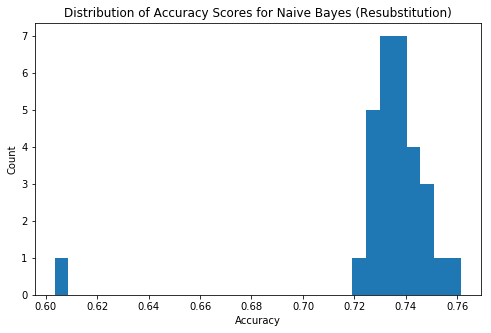

In [33]:
plotAcc(res_resub['NB Accuracy'], "Naive Bayes (Resubstitution)")

In [34]:
nb_acc = res_gen['NB Accuracy'].as_matrix()
nb_scores = classificationReport(nb_acc, CI=0.9999, nsamp=100000)

print "Mean accuracy of 30 Naive Bayes classifiers on shuffled training/testing data = {0:.2f}%" \
                                                    .format(nb_scores[0]*100)
print "Variance of accuracy from 30 Naive Bayes classifiers on shuffled training/testing data = {0:.3f}%"\
                                                    .format(nb_scores[1]*100)
print "Analytic confidence interval of 95% for accuracy has range {0:.2f}% to {1:.2f}%"\
                            .format(nb_scores[2][0]*100,nb_scores[2][1]*100)
print "Bootstrap confidence interval of 95% for accuracy has range {0:.2f}% to {1:.2f}%"\
                            .format(nb_scores[3][0]*100,nb_scores[3][2]*100)

Mean accuracy of 30 Naive Bayes classifiers on shuffled training/testing data = 72.53%
Variance of accuracy from 30 Naive Bayes classifiers on shuffled training/testing data = 0.019%
Analytic confidence interval of 95% for accuracy has range 67.17% to 77.89%
Bootstrap confidence interval of 95% for accuracy has range 71.58% to 73.45%


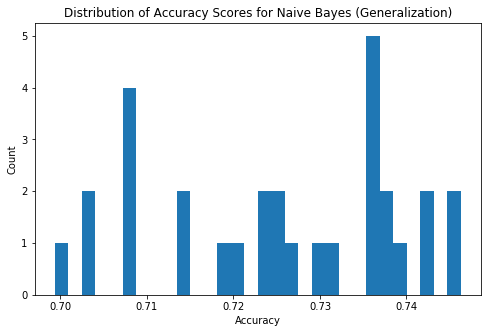

In [35]:
plotAcc(res_gen['NB Accuracy'], "Naive Bayes (Generalization)")

### t-tests

In [36]:
def comparePlots(res_df, finish_title, kind='box'):
    res_df.plot(kind=kind, figsize=(8,5))
    plt.xlabel('Model-Accuracy')
    plt.ylabel('Accuracy')
    plt.title('Comparing Distribution of Accuracy: '+finish_title)

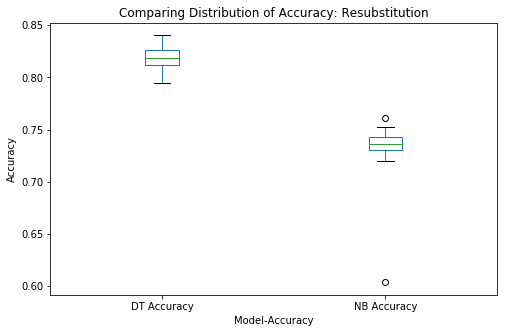

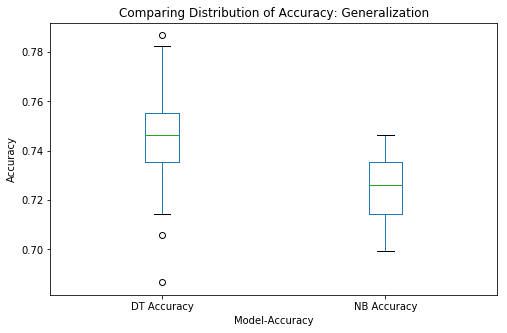

In [37]:
comparePlots(res_resub, 'Resubstitution')
comparePlots(res_gen, 'Generalization')

##### There are some outliers in the NB Accuracy frames for both resubstitution and for generalization. T-test results are below for not removing these outliers

In [38]:
stats.ttest_rel(res_resub['DT Accuracy'], res_resub['NB Accuracy'])

Ttest_relResult(statistic=16.019666158044668, pvalue=6.085528110242971e-16)

The t-statistic for resubsitution testing has a value of 16.01 which is significantly large, and a p-value well below 0.05 which indicates that it is very unlikely to be due to chance

In [39]:
stats.ttest_rel(res_gen['DT Accuracy'], res_gen['NB Accuracy'])

Ttest_relResult(statistic=4.74407900408535, pvalue=5.1642730811232024e-05)

The t-statistic for generalization testing has a value of 4.74 which is large, and a p-value well below 0.05 which indicates that it is very unlikely to be due to chance

##### These are the results for removing the outliers:

In [40]:
# takes a series as input from a dataframe
def removeOutliers(s):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    IQR = q3 - q1
    return s[(s >= q1-1.5*IQR) & (s <= q3+1.5*IQR)]

In [41]:
# criteria to remove a row is if it was an outlier for either model
# meaning that it was more than 1.5x outside the IQR

# filtering outliers from the Resubstitution models
resub_nbf_idx = removeOutliers(res_resub['NB Accuracy']).index.tolist()
resub_dtf_idx = removeOutliers(res_resub['DT Accuracy']).index.tolist()
resub_combined_idx = [x for x in resub_nbf_idx if x in resub_dtf_idx]
res_resub_f = res_resub.iloc[resub_combined_idx]

# filtering outliers from the Generalization models
gen_nbf_idx = removeOutliers(res_gen['NB Accuracy']).index.tolist()
gen_dtf_idx = removeOutliers(res_gen['DT Accuracy']).index.tolist()
gen_combined_idx = [x for x in gen_nbf_idx if x in gen_dtf_idx]
res_gen_f = res_gen.iloc[gen_combined_idx]

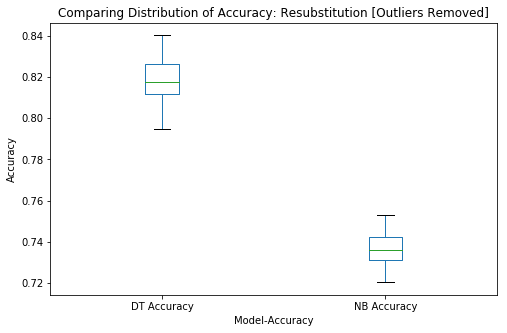

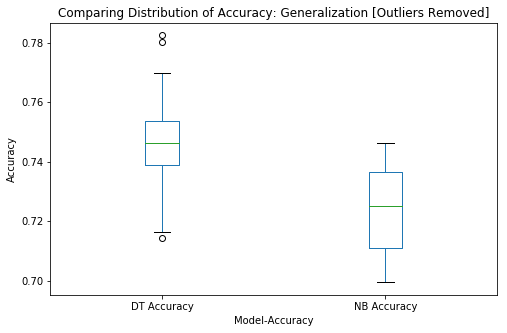

In [42]:
comparePlots(res_resub_f, 'Resubstitution [Outliers Removed]')
comparePlots(res_gen_f, 'Generalization [Outliers Removed]')

In [43]:
stats.ttest_rel(res_resub_f['DT Accuracy'], res_resub_f['NB Accuracy'])

Ttest_relResult(statistic=39.20117011980742, pvalue=2.4433046522513353e-25)

The t-statistic for resubsitution testing has a value of 38.05 which is significantly large, even more so than with outliers included. The a p-value is well below 0.05 which indicates that it is extremely unlikely to be due to chance. From this we can reject the null hypothesis that the Decision Tree and Naive Bayes classifier perform equally as well when predicting the same training data they were trained on, and can reasonably state that the two perform differently with resubtitution evaluation.

In [44]:
stats.ttest_rel(res_gen_f['DT Accuracy'], res_gen_f['NB Accuracy'])

Ttest_relResult(statistic=6.1531675752350266, pvalue=1.6605092539299863e-06)

The t-statistic for generalization testing has a value of 5.74 which is slightly larger than without the outliers removed. The p-value is well below 0.05 which indicates that it is very unlikely to be due to chance. From this we can reject the null hypothesis that the Decision Tree and Naive Bayes classifier perform equally as well when evaluating identical sets of new data after being trained on identical sets of data, and can reasonably state that the two perform differently with generalization evaluation.

### Evaluating manyRuns performance at different training and testing holdout values

In [46]:
from scipy.interpolate import spline
import warnings

In [47]:
def frange(start, stop, inc):
    while start <= stop:
        yield start
        start += inc

In [48]:
def manyRunsPlus(df, train_size_list, test='generalization', niters=30):
    frames = [manyRuns(df, test, niters, 1-tr_sz) for tr_sz in train_size_list]
    results = pd.concat(frames, keys=train_size_list)
    return results

In [49]:
train_sizes = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]

In [50]:
res_gen_many = manyRunsPlus(df2, train_sizes, test='generalization', niters=30)
res_resub_many = manyRunsPlus(df2, train_sizes, test='resubstitution', niters=30)

In [52]:
warnings.filterwarnings(action='once')

xnw = np.linspace(min(train_sizes), max(train_sizes), 1000)
gen_dt_smooth = spline(train_sizes, 
                       [1-np.mean(res_gen_many.loc[i]['DT Accuracy']) for i in train_sizes], 
                       xnw)
gen_nb_smooth = spline(train_sizes, 
                       [1-np.mean(res_gen_many.loc[i]['NB Accuracy']) for i in train_sizes], 
                       xnw)
resub_dt_smooth = spline(train_sizes, 
                       [1-np.mean(res_resub_many.loc[i]['DT Accuracy']) for i in train_sizes], 
                       xnw)
resub_nb_smooth = spline(train_sizes, 
                       [1-np.mean(res_resub_many.loc[i]['NB Accuracy']) for i in train_sizes], 
                       xnw)

C:\Users\Charlie\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


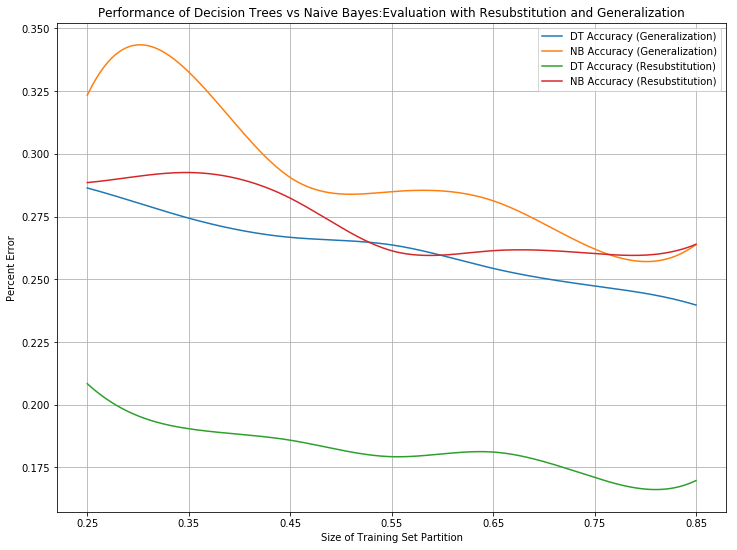

In [53]:
figure(figsize=(12,9))
plt.plot(xnw, gen_dt_smooth)
plt.plot(xnw, gen_nb_smooth)
plt.plot(xnw, resub_dt_smooth)
plt.plot(xnw, resub_nb_smooth)
plt.legend(['DT Accuracy (Generalization)',
           'NB Accuracy (Generalization)',
           'DT Accuracy (Resubstitution)',
           'NB Accuracy (Resubstitution)'])
plt.xticks([i for i in frange(0.25, 0.85, 0.10)])
plt.xlabel("Size of Training Set Partition")
plt.ylabel("Percent Error")
plt.title("Performance of Decision Trees vs Naive Bayes:\
Evaluation with Resubstitution and Generalization")
plt.grid()

In [54]:
def binaryPerfReport(ytest, ypredict, output='metrics', 
                     labs=[True, False], cols=['dinner_pred', 'not_dinner_pred'],
                     idx=['dinner_actual', 'not_dinner_actual']): 
    cm = pd.DataFrame(data=confusion_matrix(ytest, ypredict, 
                      labels=labs),
                      columns=cols,
                      index=idx)
    
    cols = ['Sensitivity', 'Specificity', 'F1', 'Accuracy']
    dfperf = pd.DataFrame(index=idx, 
                          columns=cols)
    for j in range(0, len(cm)):
        if j == 0:
            tp, fn, fp, tn = confusion_matrix(ytest, ypredict).ravel()
        elif j == 1:
            tn, fp, fn, tp = confusion_matrix(ytest, ypredict).ravel()
        
        sens = float(tp) / (tp+fn)
        spec = float(tn) / (tn+fp)
        f1 = (2*float(tp)) / (2*tp+fp+fn)
        acc = float(tp+tn) / (tp+tn+fp+fn)
        
        dfperf.iloc[j,0] = sens
        dfperf.iloc[j,1] = spec
        dfperf.iloc[j,2] = f1
        dfperf.iloc[j,3] = acc
            
    if output == 'metrics':
        return dfperf
    elif output == 'cm':
        return cm

In [55]:
#setting mood encoded to true if it is dinner (majority class). rest false
df2['mood(s)'].value_counts()

dinner     484
sleep      362
workout    326
party      248
Name: mood(s), dtype: int64

In [56]:
#making copy of dataframe and replacing moods from df2 with encoded version
df3 = df2.copy()
df3['mood(s)'] = df2['mood(s)']=='dinner'

In [57]:
#setting up pipeline for single NB classification
nb_pipe = Pipeline([
    ('myscaler', StandardScaler()),
    ('masteralg', GaussianNB(priors=None))
])

#setting up data 
df3 = df3.sample(frac=1)
t_X, t_y = df3.iloc[:,0:len(df3.columns)-1], df3['mood(s)']
t_Xtrain, t_Xtest, t_ytrain, t_ytest = train_test_split(t_X, t_y,
                                                       stratify=t_y, 
                                                       test_size=0.25)
nb_pipe.fit(t_Xtrain, t_ytrain)

Pipeline(memory=None,
     steps=[('myscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('masteralg', GaussianNB(priors=None, var_smoothing=1e-09))])

In [58]:
# running a resubtitution analysis

t_ypred = nb_pipe.predict(t_Xtrain)
binaryPerfReport(t_ytrain, t_ypred, output='cm')

,dinner_pred,not_dinner_pred
dinner_actual,318,45
not_dinner_actual,247,455


In [59]:
binaryPerfReport(t_ytrain, t_ypred, output='metrics')

,Sensitivity,Specificity,F1,Accuracy
dinner_actual,0.648148,0.876033,0.757072,0.725822
not_dinner_actual,0.876033,0.648148,0.685345,0.725822


In [60]:
# running a generalization analysis

t_ypred = nb_pipe.predict(t_Xtest)
binaryPerfReport(t_ytest, t_ypred, output='cm')

,dinner_pred,not_dinner_pred
dinner_actual,106,15
not_dinner_actual,84,150


In [61]:
binaryPerfReport(t_ytest, t_ypred, output='metrics')

,Sensitivity,Specificity,F1,Accuracy
dinner_actual,0.641026,0.876033,0.75188,0.721127
not_dinner_actual,0.876033,0.641026,0.681672,0.721127


### ROC curve

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy import interp

In [63]:
#using a sklearn recipe for getting a nice graph
def nbROC(df, test="generalization", niters=5, test_size=0.33, dinner_thresh='default'): 
    figure(figsize=(12,8))
    for i in range(0, niters):
        df = df.sample(frac=1)
        tmp_X, tmp_y = df.iloc[:, 0:len(df.columns)-1], df['mood(s)']
        tmp_Xtrain, tmp_Xtest, tmp_ytrain, tmp_ytest = train_test_split(tmp_X, tmp_y,
                                                                        stratify=tmp_y,
                                                                        test_size=test_size,
                                                                        )
        if dinner_thresh == "default":
            nb_pipe = Pipeline([
                ('myscaler', StandardScaler()),
                ('masteralg', GaussianNB())
            ])
        elif dinner_thresh == "dist":
            dinner_prob = float(tmp_ytrain.value_counts()[True]) / len(tmp_ytrain)
            ndinner_prob = 1.-dinner_prob
            nb_pipe = Pipeline([
                ('myscaler', StandardScaler()),
                ('masteralg', GaussianNB(priors=[ndinner_prob, dinner_prob]))
            ])
        elif type(dinner_thresh) == list:
            dinner_prob = dinner_thresh[1]
            ndinner_prob = dinner_thresh[0]
            nb_pipe = Pipeline([
                ('myscaler', StandardScaler()),
                ('masteralg', GaussianNB(priors=[ndinner_prob, dinner_prob]))
            ])
        
        nb_pipe.fit(tmp_Xtrain, tmp_ytrain)
        
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0,1,100)
        
        if test == "generalization":
            nb_ypred = nb_pipe.predict_proba(tmp_Xtest)
            fpr, tpr, thresholds = roc_curve(tmp_ytest, nb_ypred[:,1])
        elif test == "resubstitution":
            nb_ypred = nb_pipe.predict_proba(tmp_Xtrain)
            fpr, tpr, thresholds = roc_curve(tmp_ytrain, nb_ypred[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC run %d (AUC=%0.2f)"%(i,roc_auc))
   
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', 
             label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Naive Bayes Model: ROC Curve for {0} Runs'.format(niters))
    plt.legend(loc="lower right")
    
    #classification threshold
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='green')
    ax2.set_ylabel('Classification Threshold',color='green')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_yticks([i for i in frange(0.0,1.0,0.05)])
    ax2.set_xlim([fpr[0],fpr[-1]])
    plt.show()
    

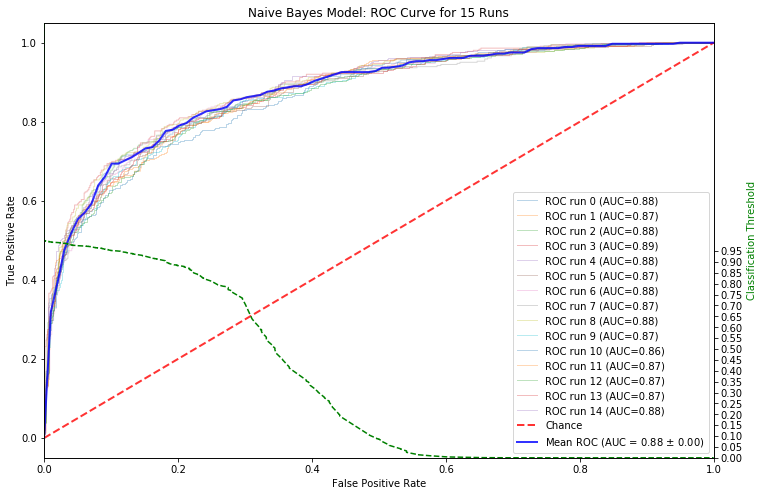

In [64]:
nbROC(df3, test='resubstitution', niters=15, test_size=0.25, dinner_thresh='default')

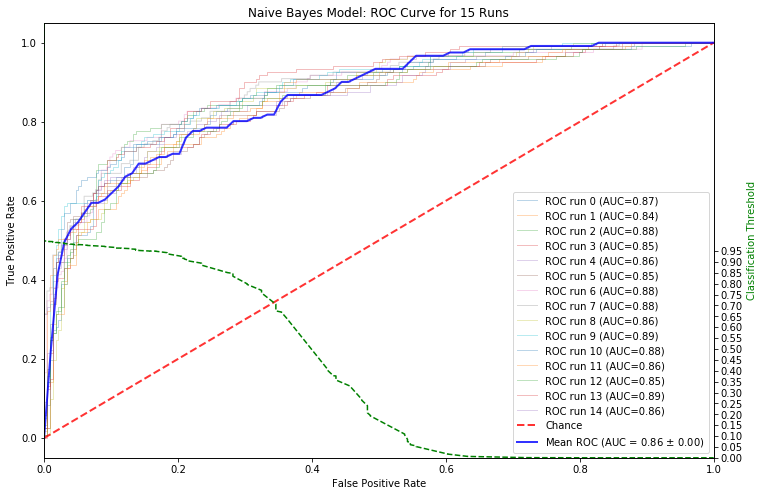

In [65]:
nbROC(df3, test='generalization', niters=15, test_size=0.25, dinner_thresh='default')

Using the chart of optimal training/testing splits, the Naive Bayes model was run with a 75/25 training/testing split. The model is very consistent for resubstitution and starts to see more variance with different testing set for the generalization runs. Given that the shortest point on the mean ROC curve appears to be around where TPR=80% and FPR=20%, I would choose the classification threshold for declaring a positive class to be around 80% since that appears to be the corresponding classification threshold

##### c.

In [66]:
#putting together dataframes of the predicted and actual labels

#resubstitution
t_ypred = nb_pipe.predict_proba(t_Xtrain)
resub_df = pd.DataFrame(data=np.array([t_ytrain, t_ypred[:,1]]).T, 
                        columns=['Actual','Predicted'], 
                        index=t_ytrain.index)
resub_df.to_csv("resub_df.csv")

#generalization
t_ypred = nb_pipe.predict_proba(t_Xtest)
gen_df = pd.DataFrame(data=np.array([t_ytest, t_ypred[:,1]]).T, 
                        columns=['Actual','Predicted'], 
                        index=t_ytest.index)
gen_df.to_csv("gen_df.csv")